In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyam
import pymagicc
import scmdata
import silicone.multiple_infillers as mi
import sys

<IPython.core.display.Javascript object>

In [2]:
sys.path.insert(0, '..')

In [3]:
import scripts.utils

In [4]:
sr15 = pyam.IamDataFrame("..\input\complete_sr15_emissions.csv").filter(region="World")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\input\complete_sr15_emissions.csv


In [5]:
rcmip = pyam.IamDataFrame("../input/rcmip-emissions-annual-means-v5-1-0.csv")

pyam.core - INFO: Reading file ..\input\rcmip-emissions-annual-means-v5-1-0.csv


In [6]:
rcmip.filter(scenario="ssp534-over").model

['REMIND-MAGPIE']

In [7]:
version = "v5"
outdir = f'../output/chosen_files/{version}/'
scen_file = outdir + "scen_{}"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [8]:
med_temp = 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED'
sr15.set_meta(meta='uncategorized', name='warming_category')
sr15.categorize(
    'warming_category', 'below 1.6C',
    criteria={med_temp: {'up': 1.6, 'lo': 1.5, 'year': 2100}},
    color='xkcd:blue'
)
sr15.categorize(
    'warming_category', 'below 1.5C',
    criteria={med_temp: {'up': 1.5, 'year': 2100}},
    color='xkcd:baby blue'
)

pyam.core - INFO: No scenarios satisfy the criteria
pyam.core - INFO: No scenarios satisfy the criteria


In [9]:
peak = 'peak_temperature'
sr15.set_meta_from_data(name=peak, variable=med_temp, method=np.max)

pyam.core - WARNING: Filtered IamDataFrame is empty!


In [10]:
sr15.filter(
    peak_temperature=[x for x in sr15.meta.peak_temperature if x < 2 and x > 1.8], scenario="SSP*"
)

pyam.core - WARNING: Filtered IamDataFrame is empty!


<class 'pyam.core.IamDataFrame'>
Index:
 * model    : (0)
 * scenario : (0)
Timeseries data coordinates:
   region   : (0)
   variable : (0)
   unit     : (0)
   year     : (0)
Meta indicators:
   exclude (bool) (0)
   warming_category (object) (0)
   peak_temperature (object) (0)

In [11]:
sr15.filter(scenario="SSP*").model

['AIM/CGE 2.0',
 'GCAM 4.2',
 'IMAGE 3.0.1',
 'MESSAGE-GLOBIOM 1.0',
 'REMIND-MAgPIE 1.5',
 'WITCH-GLOBIOM 3.1']

In [12]:
rcmip.scenario

['esm-bell-1000PgC',
 'esm-bell-2000PgC',
 'esm-bell-750PgC',
 'esm-pi-CO2pulse',
 'esm-pi-cdr-pulse',
 'esm-piControl',
 'historical',
 'historical-cmip5',
 'rcp26',
 'rcp45',
 'rcp60',
 'rcp85',
 'ssp119',
 'ssp126',
 'ssp245',
 'ssp370',
 'ssp370-lowNTCF-aerchemmip',
 'ssp370-lowNTCF-gidden',
 'ssp434',
 'ssp460',
 'ssp534-over',
 'ssp585']

In [13]:
rcmip.filter(scenario="ssp119")

<class 'pyam.core.IamDataFrame'>
Index:
 * model       : IMAGE (1)
 * scenario    : ssp119 (1)
Timeseries data coordinates:
   region      : World, World|R5.2ASIA, World|R5.2LAM, ... World|R5.2REF (6)
   variable    : Emissions|BC, ... (182)
   unit        : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2/yr, ... kt cC4F8/yr (51)
   year        : 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, ... 2500 (315)
   mip_era     : CMIP6 (1)
   activity_id : not_applicable (1)
Meta indicators:
   exclude (bool) False (1)

In [14]:
desired_scenarios = []
desired_scenarios.append(rcmip.filter(model="REMIND-MAGPIE", scenario="ssp534-over"))
desired_scenarios.append(rcmip.filter(model="IMAGE", scenario="ssp119"))

In [15]:
df = pyam.concat(desired_scenarios).filter(region="World", variable="Emissions*")

# Infill the missing emissions

In [16]:
df = df.data
del df["activity_id"]
del df["mip_era"]

In [17]:
df["variable"] = df["variable"].str.replace("MAGICC AFOLU", "AFOLU").replace(
    "MAGICC Fossil and Industrial", "Energy and Industrial Processes"
)

In [18]:
df = pyam.IamDataFrame(df)

In [19]:
missing_emissions = [
    'Emissions|PFC|C2F6', 'Emissions|HFC|HFC43-10', 'Emissions|PFC|C6F14', 'Emissions|HFC|HFC125', 
    'Emissions|HFC|HFC32', 'Emissions|HFC|HFC143a', 'Emissions|HFC|HFC245fa', 'Emissions|HFC|HFC23', 
    'Emissions|HFC|HFC134a', 'Emissions|SF6', 'Emissions|PFC|CF4', 'Emissions|HFC|HFC227ea', 
]
leader = "Emissions|CO2"
cent = [y for y in df.year if y<=2100 and y > 2000]
infillee_df = df.filter(year=cent, variable=leader)

In [20]:
for em in missing_emissions:
    is_empty = sr15.filter(region="World", variable=em).empty
    if is_empty:
        print(em)

In [21]:
infilled_df = mi.infill_all_required_variables(
    infillee_df.filter(year=cent), 
    sr15.filter(region="World", year=cent), [leader], 
    required_variables_list=missing_emissions
)

Filling required variables: 100%|██████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.34it/s]


In [22]:
df = infilled_df.append(df.filter(variable="Emissions|CO2", keep=False))

In [23]:
normal_years = [2015] + list(np.arange(2020, 2101, 10))
normal_years
bad_vars = [
    "*Sulfur|*", "*|BC|*", "*CH4|*", "Emissions|Montreal Gases|*", "Emissions|VOC|*", 
    "Emissions|NH3|*", "Emissions|NOx|*", "Emissions|OC|*", "Emissions|CO|*", 
]

In [24]:
for scenario in df.scenario:
    scripts.utils.construct_scen_file(
        df.filter(scenario=scenario, variable="Emissions|*", year=normal_years).filter(
            variable=bad_vars, keep=False
        ), 
        scen_file.format(scenario)
    )

pyam.utils - WARNING: Formatted data is empty!
pyam.utils - WARNING: Formatted data is empty!


In [25]:
scen_file

'../output/chosen_files/v5/scen_{}'

# Also can select scenarios from complete tiling

In [26]:
date_str = "2022-03-15"
version = "v5"
fair_output_dir = "../output/{}/fair/".format(version)
runs_quantiles = pd.read_csv('{}fair_output_quantiles_{}_{}.csv'.format(fair_output_dir, date_str, version))
runs_quantiles.head()

,climate_model,model,region,scenario,unit,variable,quantile,2010,2011,2012,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.1,K,Surface Temperature,0.1,0.931664,0.949297,0.967368,...,0.099868,0.096647,0.093437,0.090239,0.087053,0.083879,0.080717,0.077567,0.074429,0.071302
1,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.25,K,Surface Temperature,0.1,0.931664,0.949297,0.967368,...,0.135194,0.132734,0.130283,0.127841,0.125408,0.122984,0.120374,0.117310,0.114259,0.111219
2,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.5,K,Surface Temperature,0.1,0.931664,0.949297,0.967368,...,0.175823,0.173365,0.170916,0.168477,0.166046,0.163624,0.161211,0.158807,0.156412,0.154026
3,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.75,K,Surface Temperature,0.1,0.931664,0.949297,0.967368,...,0.247033,0.244419,0.241771,0.238736,0.235823,0.233404,0.230993,0.228591,0.226198,0.223814
4,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.9,K,Surface Temperature,0.1,0.931664,0.949297,0.967368,...,0.367415,0.364812,0.362219,0.359636,0.357062,0.354498,0.351943,0.349399,0.346864,0.344338


C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Legend does not support 3762 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Legend does not support 4188 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Legend does not support 4377 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:17: UserWa

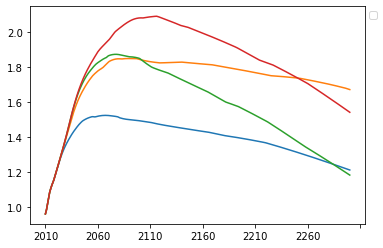

In [27]:
illustrative_scens = [
    "scen_2030fact1.32_nz2080_ov-10000_meth0.5", 
    "scen_2030fact0.72_nz2070_ov-5000_meth0.5",
    "scen_2030fact1.32_nz2100_ov-10000_meth0.5",
    "scen_2030fact1.12_nz2080_ov-5000_meth0.75", 
]
plotcols = [str(x) for x in range(2010, 2301)]
ax=plt.subplot(111)
runs_quantiles.loc[
    (runs_quantiles["quantile"]==0.5) & [s in illustrative_scens for s in runs_quantiles["scenario"]], plotcols
].T.plot(ax=ax)
ax.legend(
    runs_quantiles.loc[
        (runs_quantiles["quantile"]==0.5) & [s in illustrative_scens for s in runs_quantiles["scenario"]], :
    ].index, 
    illustrative_scens, 
    bbox_to_anchor=(1.05, 1)
)

In [28]:
runs_quantiles.loc[(runs_quantiles["quantile"]==0.5) & [s in illustrative_scens for s in runs_quantiles["scenario"]], :].index

Int64Index([3762, 4188, 4377, 4427], dtype='int64')

In [29]:
runs_quantiles.columns

Index(['climate_model', 'model', 'region', 'scenario', 'unit', 'variable',
       'quantile', '2010', '2011', '2012',
       ...
       '2291', '2292', '2293', '2294', '2295', '2296', '2297', '2298', '2299',
       '2300'],
      dtype='object', length=298)